Import libraries

In [143]:
# download yake library
!pip install yake

In [144]:
import yake
import pandas as pd
import requests
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

NYT API

In [145]:
API_NYtimes = 'YOUR_NYT_API_KEY'

Parsing content

In [197]:
mp_emailed = requests.get(f'https://api.nytimes.com/svc/mostpopular/v2/emailed/1.json?api-key={API_NYtimes}').json()
mp_shared = requests.get(f'https://api.nytimes.com/svc/mostpopular/v2/shared/1/facebook.json?api-key={API_NYtimes}').json()
mp_viewed = requests.get(f'https://api.nytimes.com/svc/mostpopular/v2/viewed/1.json?api-key={API_NYtimes}').json()

In [198]:
mp_emailed = pd.DataFrame(mp_emailed)
mp_shared = pd.DataFrame(mp_shared)
mp_viewed = pd.DataFrame(mp_viewed)

In [199]:
mp_viewed.head(5)

,status,copyright,num_results,results
0,OK,Copyright (c) 2021 The New York Times Company....,20,{'uri': 'nyt://article/259cf542-5e83-57bd-bc16...
1,OK,Copyright (c) 2021 The New York Times Company....,20,{'uri': 'nyt://article/d44ee463-9e46-58d5-8b12...
2,OK,Copyright (c) 2021 The New York Times Company....,20,{'uri': 'nyt://article/7b674c9e-c151-5d51-a25a...
3,OK,Copyright (c) 2021 The New York Times Company....,20,{'uri': 'nyt://article/b6dae70f-dd5b-5ee6-9100...
4,OK,Copyright (c) 2021 The New York Times Company....,20,{'uri': 'nyt://article/c89de937-4ac7-5cc9-b9aa...


In [200]:
# Extraction of main info from results

adx_keywords = []
abstract = []
des_facet = []
caption = []
org_facet = []
per_facet = []
title = []
published_date = []
url = []

for article in mp_emailed['results']:
    adx_keywords.append(article['adx_keywords']) 
    abstract.append(article['abstract'])
    des_facet.append(article['des_facet'])
    try:
        caption.append(article['media'][0]['caption'])
    except:
        caption.append(None)
    org_facet.append(article['org_facet'])
    per_facet.append(article['per_facet'])
    title.append(article['title'])
    published_date.append(article['published_date'])
    url.append(article['url'])
for article in mp_viewed['results']:
    adx_keywords.append(article['adx_keywords']) 
    abstract.append(article['abstract'])
    des_facet.append(article['des_facet'])
    try:
        caption.append(article['media'][0]['caption'])
    except:
        caption.append(None)
    org_facet.append(article['org_facet'])
    per_facet.append(article['per_facet'])
    title.append(article['title'])
    published_date.append(article['published_date'])
    url.append(article['url'])
for article in mp_shared['results']:
    adx_keywords.append(article['adx_keywords']) 
    abstract.append(article['abstract'])
    des_facet.append(article['des_facet'])
    try:
        caption.append(article['media'][0]['caption'])
    except:
        caption.append(None)
    org_facet.append(article['org_facet'])
    per_facet.append(article['per_facet'])
    title.append(article['title'])
    published_date.append(article['published_date'])
    url.append(article['url'])

# create table with extracted info

df_pop = pd.DataFrame()
df_pop['title'] = title
df_pop['published_date'] = published_date
df_pop['caption'] = caption
df_pop['abstract'] = abstract
df_pop['des_facet'] = des_facet
df_pop['org_facet'] = org_facet
df_pop['per_facet'] = per_facet
df_pop['adx_keywords'] = adx_keywords
df_pop['url'] = url

Keywords model

In [201]:
# a model that return a phrase that consists of one or two words
# def def_keywords(text):
#     kw_extractor = yake.KeywordExtractor()
#     language = "en"
#     max_ngram_size = 2
#     deduplication_threshold = 0.9
#     numOfKeywords = 20
#     custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
#     keywords = custom_kw_extractor.extract_keywords(text)
#     return ';'.join([x[0] for x in keywords])

# a model that return a phrase that consists of one word
def def_keywords(text):
    kw_extractor = yake.KeywordExtractor()
    language = "en"
    max_ngram_size = 2
    deduplication_threshold = 0.9
    numOfKeywords = 30
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)
    keywords = [x for x in keywords if len(x[0].split(' ')) == 2]
    return ';'.join([x[0] for x in keywords])

# Exctract keywords from caption and abstract with model
df_pop['caption_kw'] = df_pop['caption'].apply(lambda x: def_keywords(x))
df_pop['abstract_kw'] = df_pop['abstract'].apply(lambda x: def_keywords(x))

Warning! Exception: object of type 'NoneType' has no len() generated by the following text: 'None' 
Warning! Exception: object of type 'NoneType' has no len() generated by the following text: 'None' 
Warning! Exception: object of type 'NoneType' has no len() generated by the following text: 'None' 


In [202]:
# Create list with all keywords
words = []
for i in df_pop['adx_keywords']:
    for j in i.split(';'):
        words.append(j)

# count keywords and get 15 most frequent ones

counts = [words.count(x) for x in words]
df_heat = pd.DataFrame()
df_heat['words'] = words
df_heat['count'] = counts

df_heat.sort_values(by = 'count', ascending=False, inplace=True)
df_heat.drop_duplicates(inplace=True)
df_heat = df_heat.head(15)

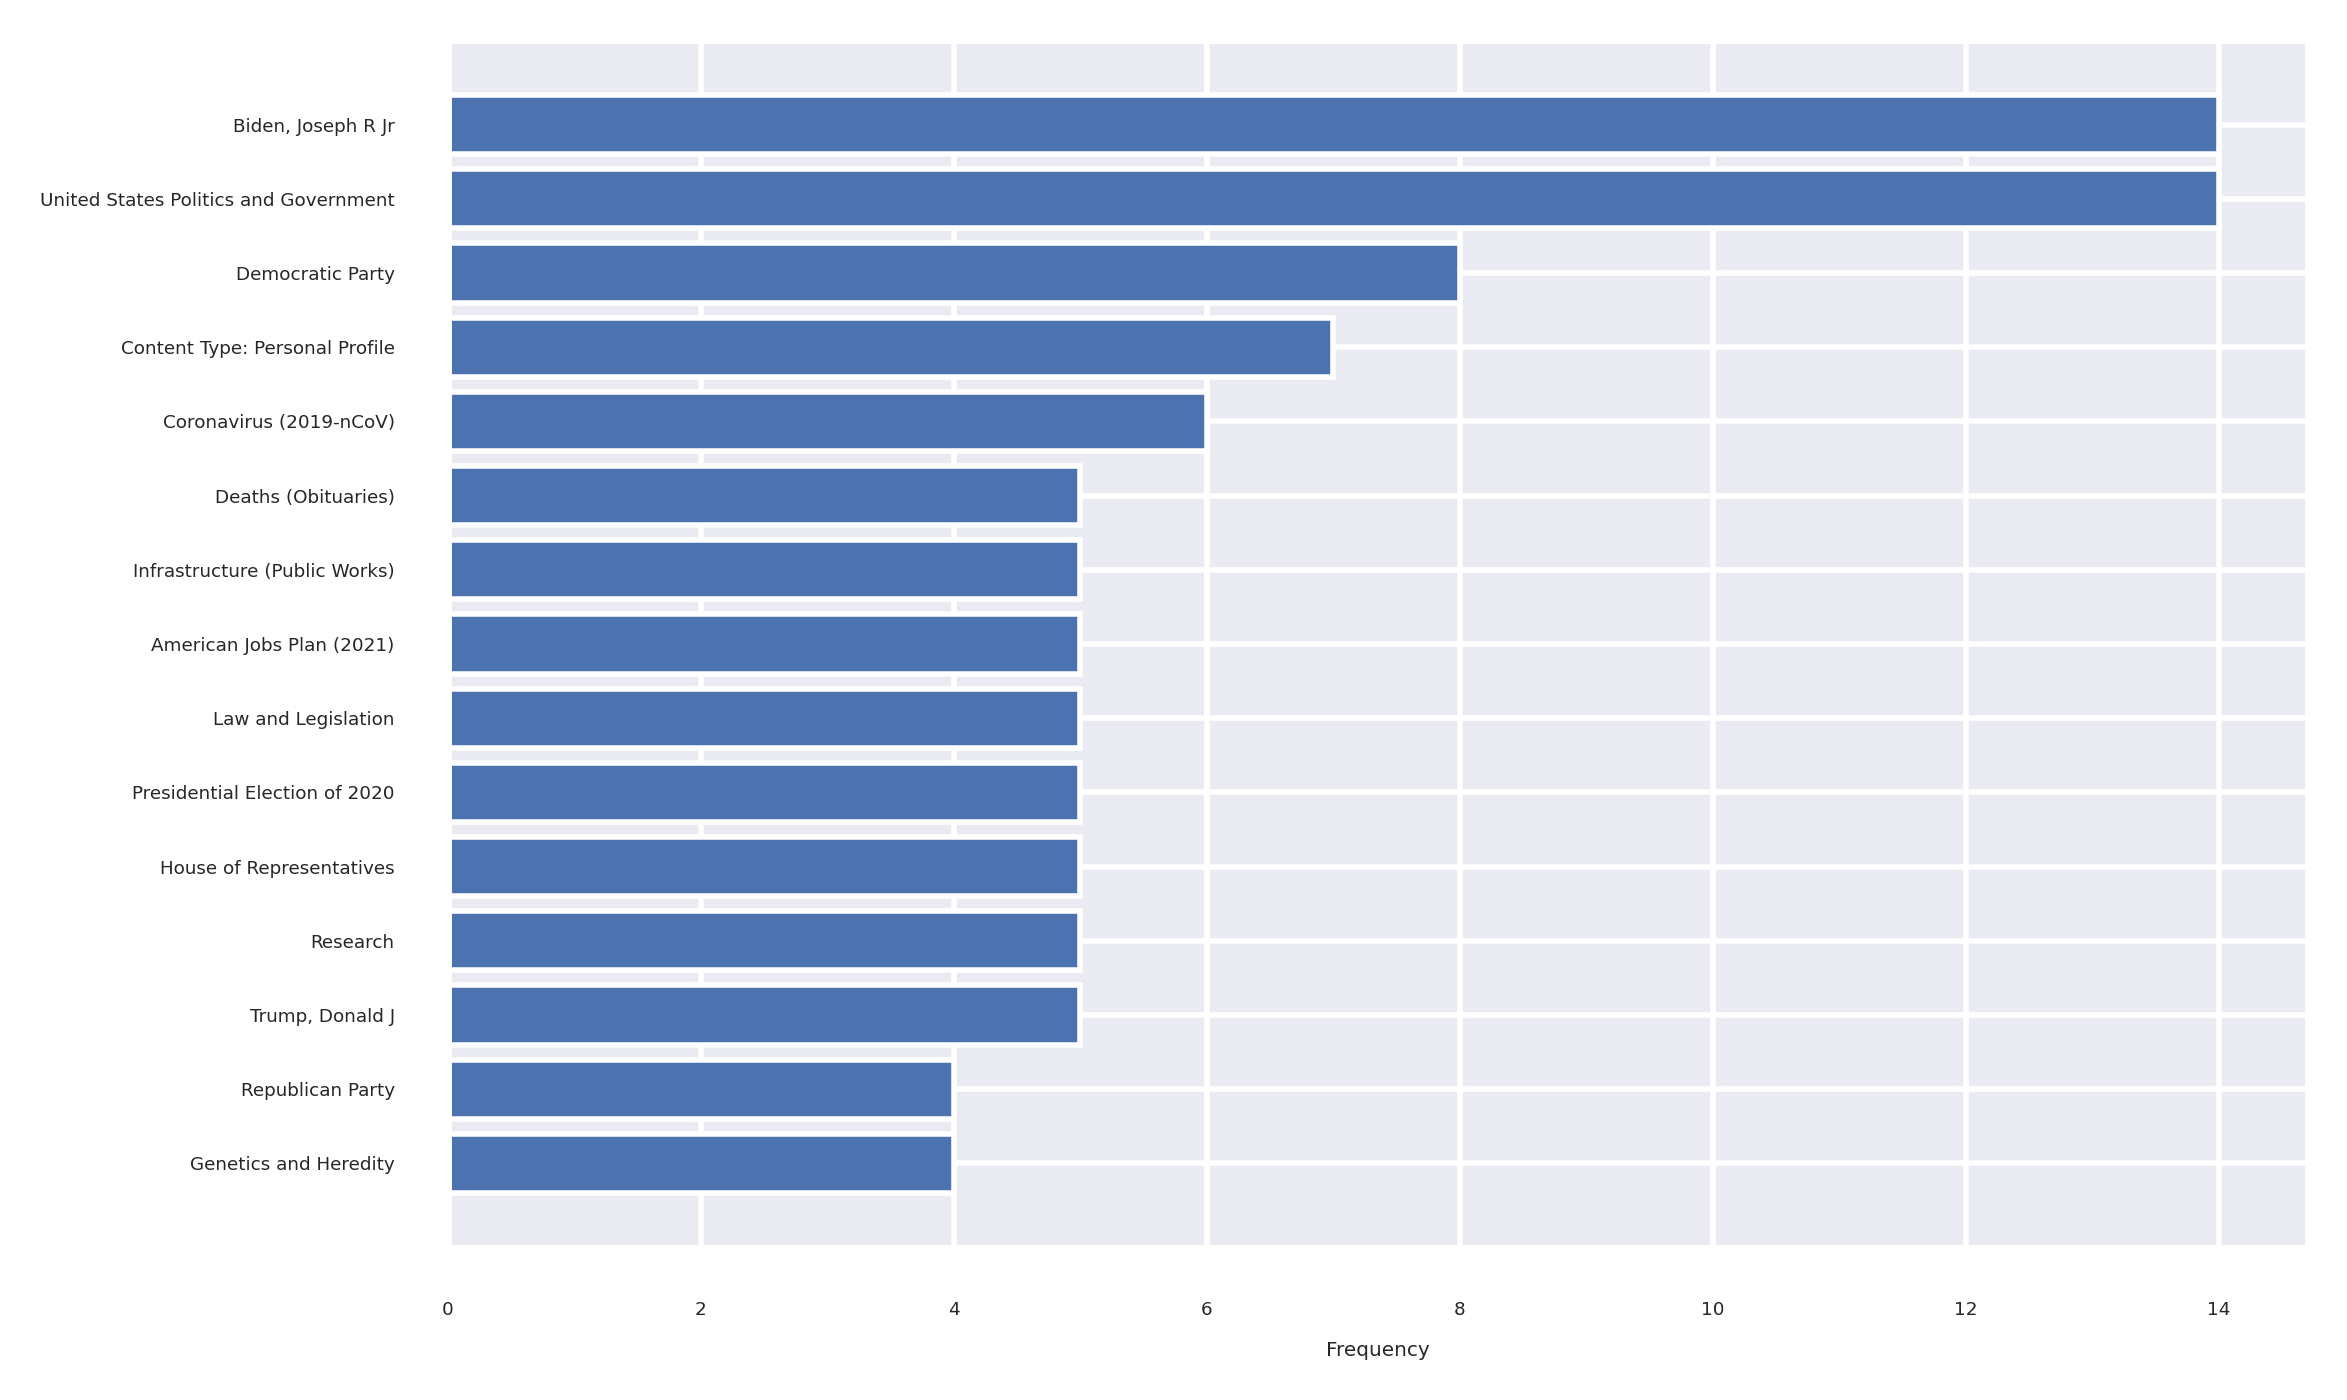

In [203]:
# Visualization of keywords frequancy

fig, ax = plt.subplots(dpi=400)
ax.barh(df_heat['words'], df_heat['count'], align='center')
y_pos = np.arange(len(df_heat['words']))
ax.set_yticks(y_pos)
ax.set_yticklabels(df_heat['words'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')

plt.show()

Keywords and context words

In [204]:
# Context keywords frequency
df_w_heatmap = df_heat.copy()
kw_all = []
for i in df_pop['caption_kw']:
    for j in i.split(';'):
        kw_all.append(j)
for i in df_pop['abstract_kw']:
    for j in i.split(';'):
        kw_all.append(j)
kw_all = [x for x in kw_all if x != '']

kw_all_count = [kw_all.count(x) for x in kw_all]
kw_all_df = pd.DataFrame()
kw_all_df['kw'] = kw_all
kw_all_df['count'] = kw_all_count
kw_all_df.drop_duplicates(inplace=True)
kw_all_df.sort_values(by='count', ascending=False, inplace=True)
kw_all_df = kw_all_df.head(20)

df_pop.reset_index(drop=True, inplace=True)
all_w = []
def def_cw_cat(text):
    global all_w
    lst_cat = []
    index = 0
    while index < len(df_pop['title']):
        if text in df_pop['adx_keywords'][index]:
            for i in df_pop['caption_kw'][index].split(';'):
                lst_cat.append(i)
            for i in df_pop['abstract_kw'][index].split(';'):
                lst_cat.append(i)
        index += 1
    lst_cat = [x for x in lst_cat if x != '']
    c = Counter(lst_cat)
    all_w += [x[0] for x in c.most_common(5)]
    return c.most_common(5)
all_w = list(dict.fromkeys(all_w))
df_w_heatmap['cw_cat'] = df_w_heatmap['words'].apply(lambda x: def_cw_cat(x))

# Create dataframe for heatmap

df_w_heatmap.reset_index(drop=True, inplace=True)

for i in all_w:
    lst_df = []
    for j in df_w_heatmap['cw_cat']:
        add_lst = [x[1] for x in j if x[0] == i]
        if len([x for x in add_lst if x != '']) != 0:
            lst_df += add_lst
        else:
            lst_df.append('')
    df_w_heatmap[i] = lst_df
df_w_heatmap.index = df_w_heatmap['words']
df_w_heatmap.drop(['words', 'count', 'cw_cat'], 1, inplace=True)

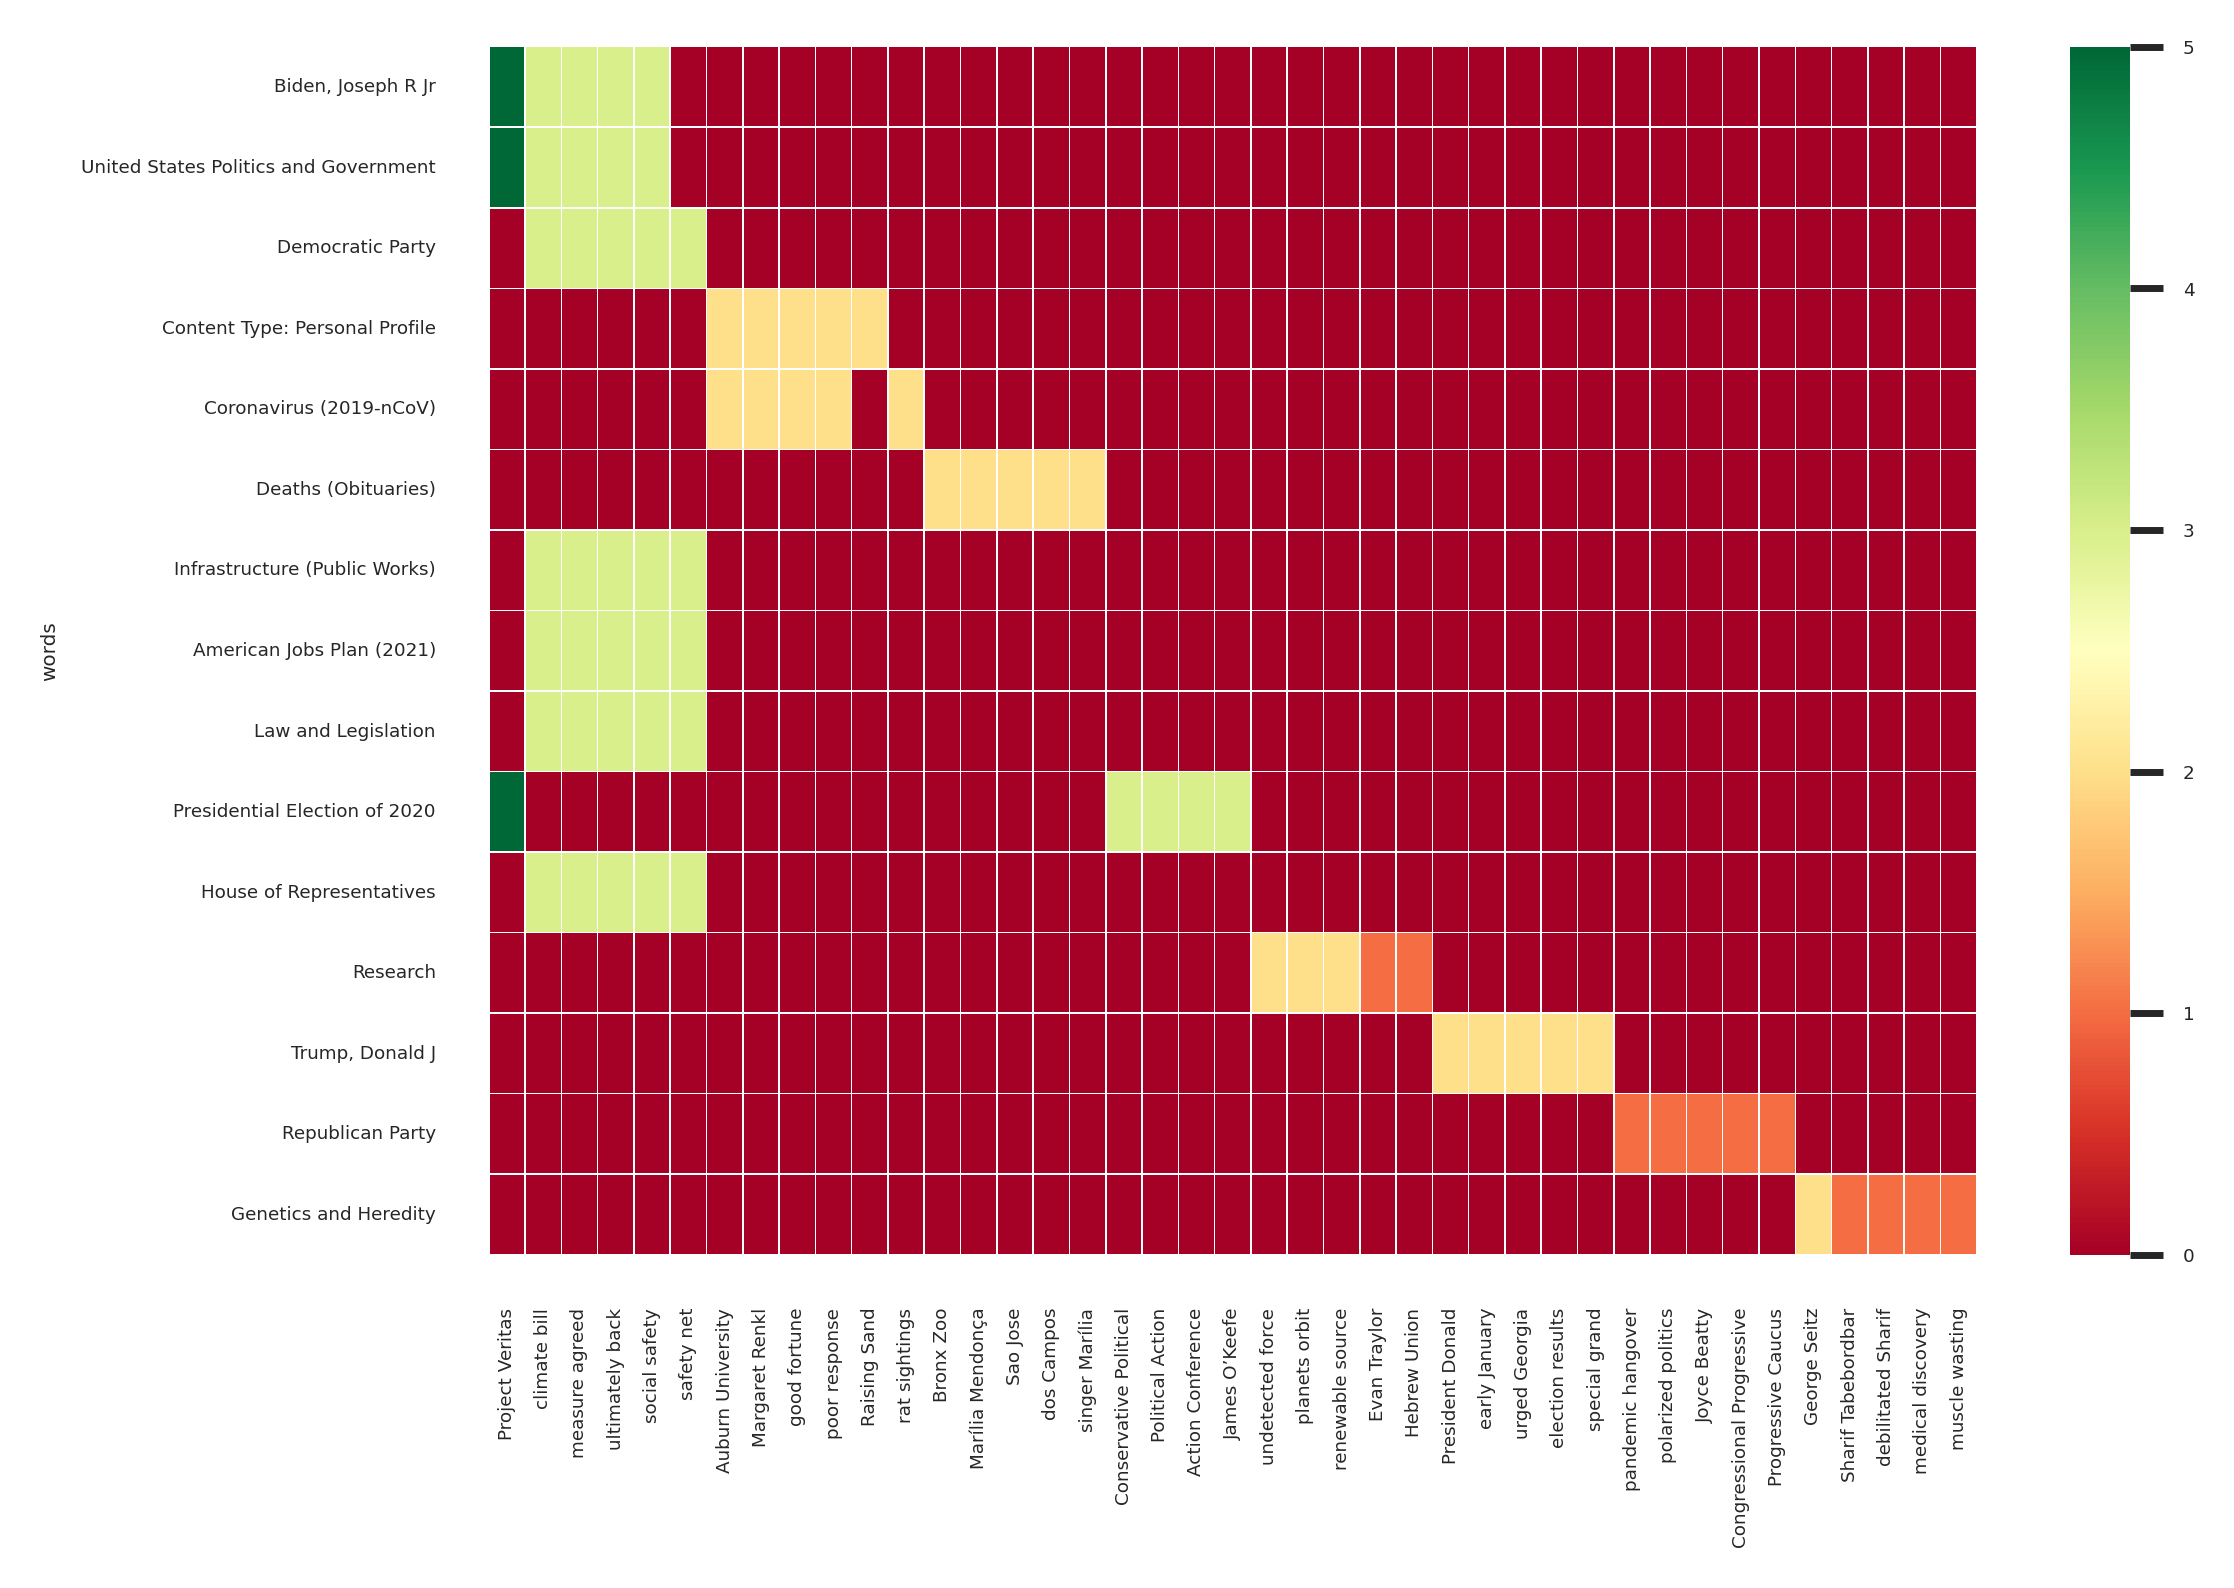

In [205]:
# Visualize heatmap
plt.figure(dpi = 400) 
sns.set(font_scale=0.3)
sns.heatmap(df_w_heatmap.replace('', 0), cmap='RdYlGn', fmt="", linewidths=0.1)

Key persons

In [206]:
# Create list with all key persons
persons = []
for i in df_pop['per_facet']:
    try:
        for j in i[0].split(';'):
            persons.append(j)  
    except IndexError:
        pass

# count key persons and get 15 most frequent ones

count_per = [persons.count(x) for x in persons]
df_heat_per = pd.DataFrame()
df_heat_per['person'] = persons
df_heat_per['count'] = count_per

df_heat_per.drop_duplicates(inplace=True)
df_heat_per.sort_values(by='count', ascending=False, inplace=True)
df_heat_per = df_heat_per.head(15)

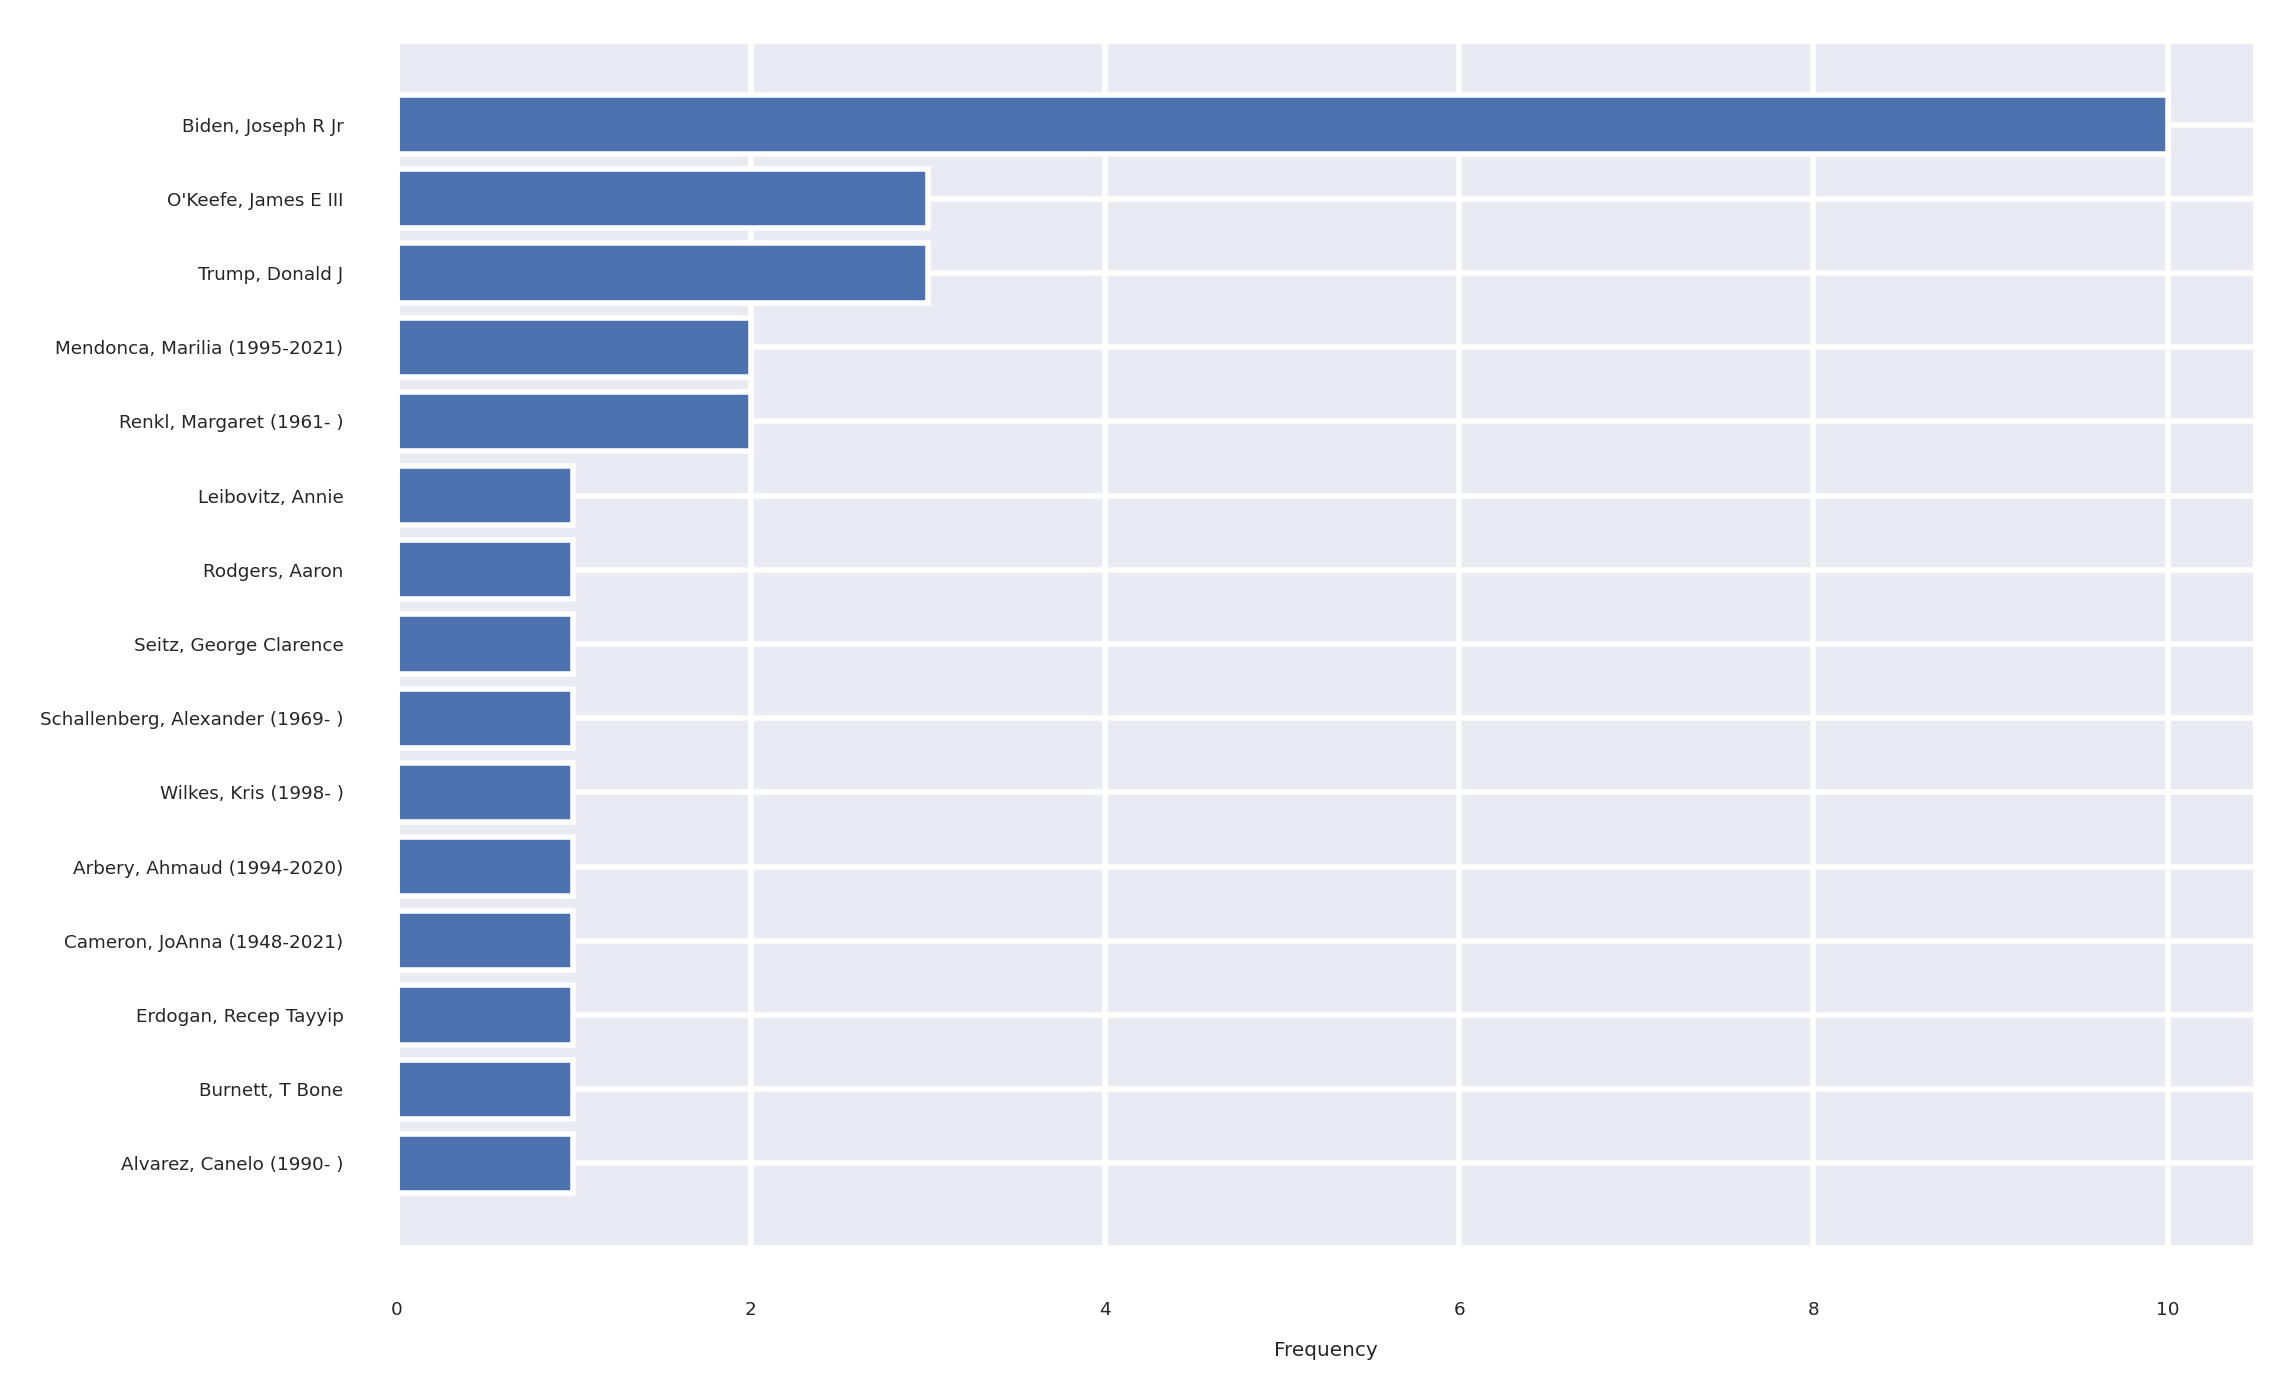

In [207]:
# Visualize key persons
fig, ax = plt.subplots(dpi=400)

ax.barh(df_heat_per['person'], df_heat_per['count'], align='center')
y_pos = np.arange(len(df_heat_per['person']))
ax.set_yticks(y_pos)
ax.set_yticklabels(df_heat_per['person'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')

plt.show()